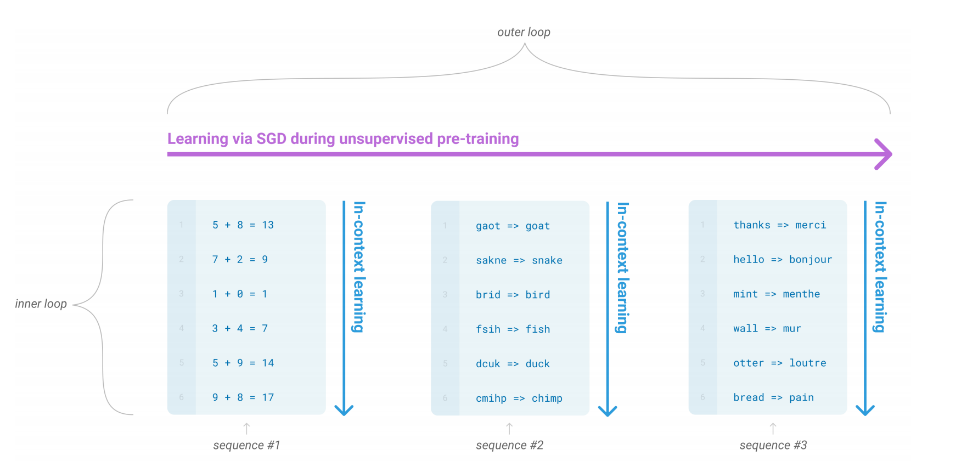

# 5.1 일관성 있는 텍스트 생성의 어려움

1. 기존의 작업
    1. 사전 훈련과 지도 학습 기반의 미세 튜닝을 조합해 NLP 문제를 다룸
    2. 시퀀스나 토큰 분류 같이 작업에 특화된 헤드에서 예측 생성은 매우 간단 -> 모델이 로짓을 출력 후 최댓값을 선택해 예측 클래스를 얻음 or 소프트맥스 함수를 적용해 클래스별 예측 확률을 얻음

2. 텍스트 생성에만 따르는 특수한 어려움
    1. 모델의 확률 출력을 텍스트로 변환하려면 디코딩 방법이 필요
        1. 디코딩은 반복적으로 수행되므로 입력이 모델의 정방향 패스를 한 번 통과할 때보다 많은 계산이 필요
        2. 생성된 텍스트의 품질과 다양성은 디코딩 방법과 이에 관련된 하이퍼파라미터에 따라 달라짐
3. 토큰 예측 과정
    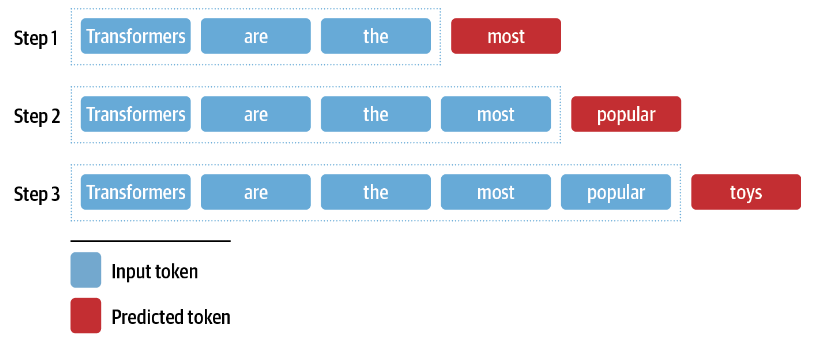
4. 과정의 핵심
    1. 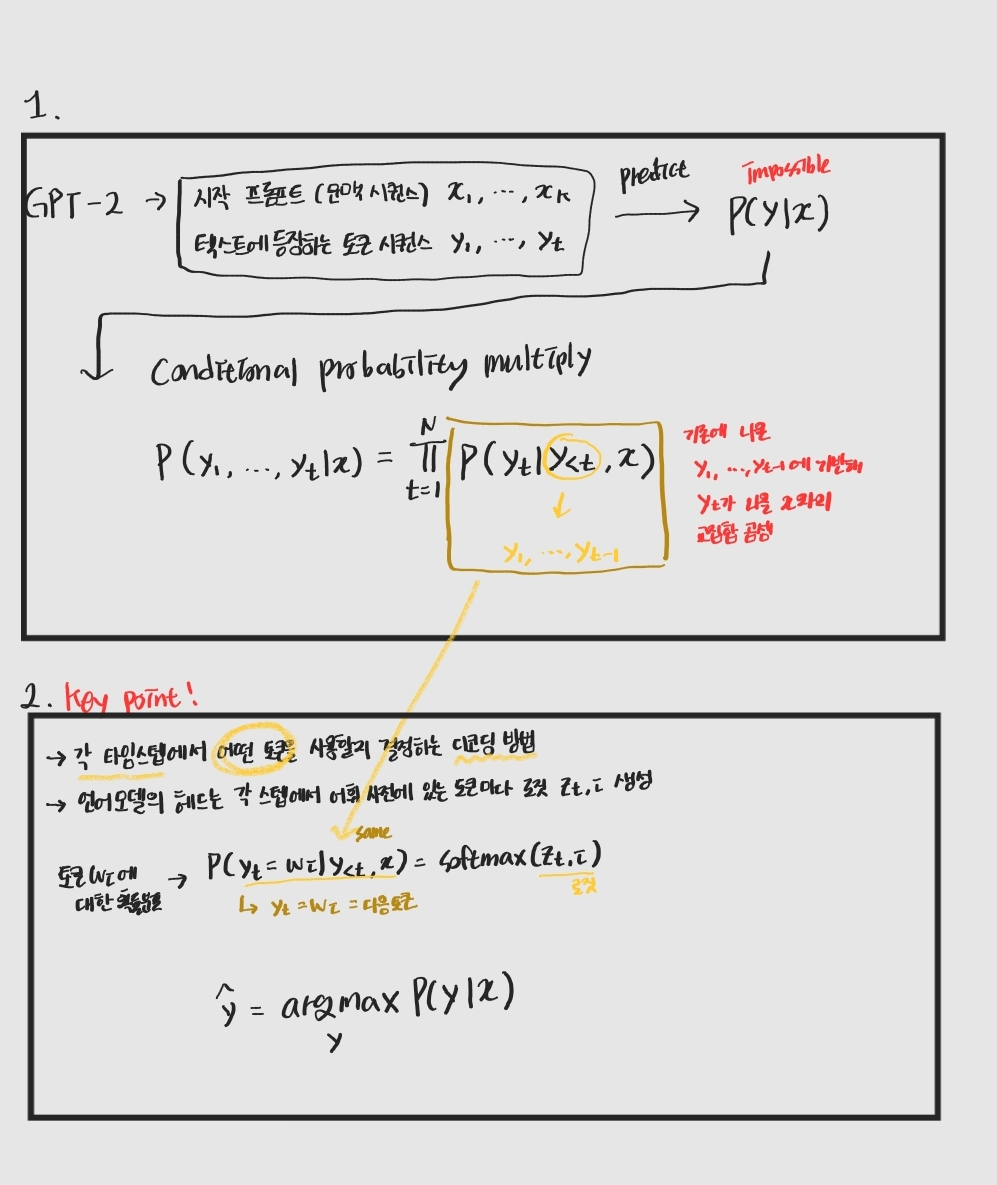

# 5.2 그리디 서치 디코딩(Greedy Search Decoding)

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [2]:
#Build decoding method to understand operation of 'generate()' function
#In each time stamp, select logt for prompt's last token and apply softmax, get probability distribution

import pandas as pd

input_txt = "Eating is the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        #Select last token's logit in first batch and apply softmax function
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        #Save token in highest probability
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        #Add predicted token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Eating is the,best (12.38%),most (11.48%),only (7.25%),key (4.88%),main (2.40%)
1,Eating is the best,way (43.88%),medicine (8.15%),thing (4.76%),form (4.71%),cure (2.40%)
2,Eating is the best way,to (89.56%),for (3.34%),of (2.40%),I (1.14%),we (0.44%)
3,Eating is the best way to,get (8.61%),lose (4.56%),keep (3.71%),stay (2.87%),make (2.01%)
4,Eating is the best way to get,rid (9.86%),your (8.85%),the (8.45%),a (5.82%),in (5.55%)
5,Eating is the best way to get rid,of (99.46%),off (0.22%),the (0.02%),or (0.02%),", (0.02%)"
6,Eating is the best way to get rid of,the (14.63%),toxins (3.71%),your (3.34%),that (3.22%),parasites (2.63%)
7,Eating is the best way to get rid of the,toxins (2.82%),bad (2.57%),excess (2.32%),fat (2.05%),bacteria (1.64%)


In [3]:
#using generate() function
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens = n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Eating is the best way to get rid of the toxins


In [ ]:
#Long text sequence
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

1. 그리드 서치 디코딩의 단점 
    - 그리드 서치 디코딩은 반복적인 출력 시퀀스를 생성하는 경향이 있어 뉴스 기사로는 적절하지 않음 -> 기여한 대학이 여러 개인 예시에서 확인 가능
    - 확률이 높은 단어가 확률이 낮은 단어보다 먼저 등장하기 때문에 전체적으로 확률이 높은 단어 시퀀스를 생성하지 못한다는 단점

# 5.3 빔 서치 디코딩

1. 확률이 가장 높은 상위 b개의 다음 토큰을 추적 (b는 'beam' or 'partial hypothesis'의 개수)
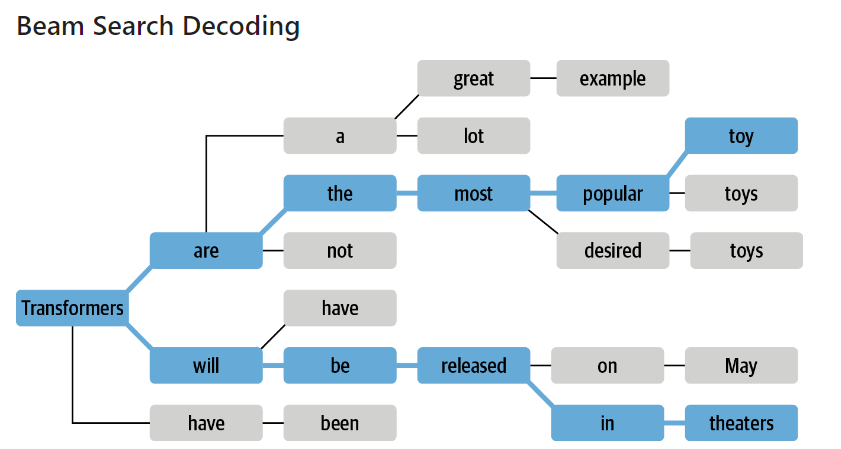
2. 확률이 아닌 로그 확률을 사용해 시퀀스 점수를 매기는 이유
    1. Sequence의 전체 확률 계산을 위해서는 조건부 확률 계산이 필수적인데 이는 [0,1] 사이에 위치한 작은 값이기에 모두 곱하게 되면 underflow가 발생할 확률이 높아짐 -> 이를 막기 위해 전체 로그화(상대적 확률만 비교하면 되니까 사용 가능)

In [ ]:
#트랜스포머 모델은 입력 토큰이 주어지면 다음 토큰에 대한 정규화되지 않은 로짓 반환 
#-> 로짓 먼저 정규화해서 시퀀스의 각 토큰을 위해 전체 어휘사전에 대한 확률 분포를 만들고 시퀀스에 있는 토큰 확률만 선택
#하나의 토큰에 대한 로그 확률 제공

import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1) #Add dimention to calculate and remove that after caculation
    return logp_label

In [ ]:
#각 토큰의 로그 확률 더하기
#Model didn't generate input sequence, so ignore prob of that.

def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In [ ]:
#To avoid repetitive problem, using no_repeat_ngram_size
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

# 5.4 샘플링 방법

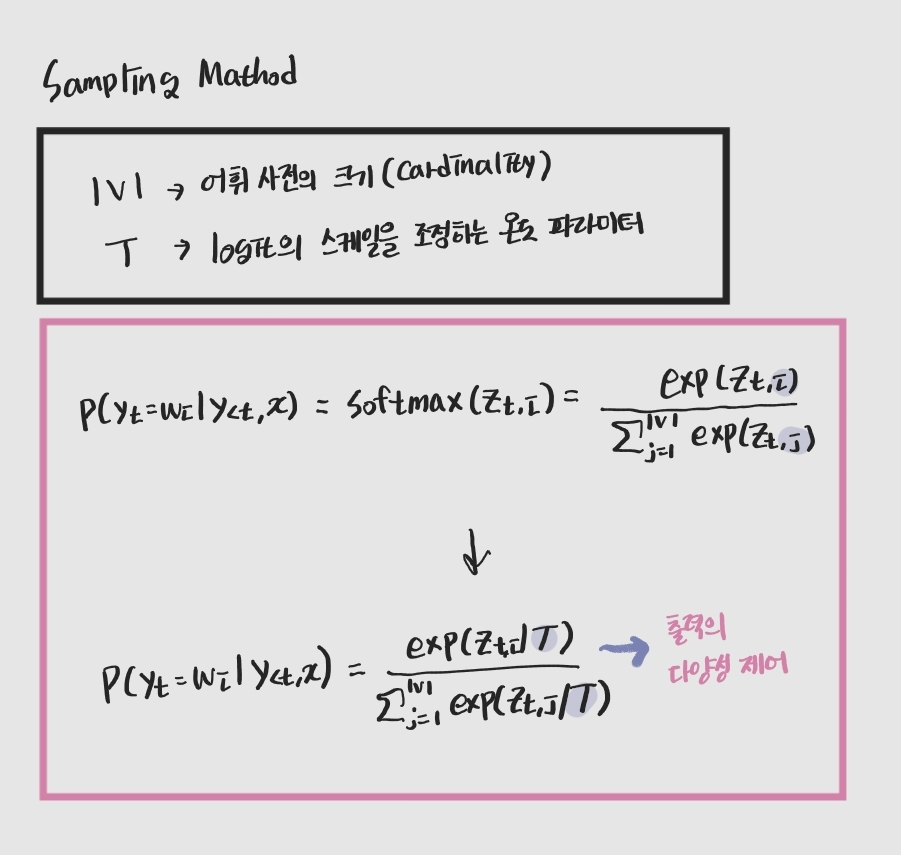
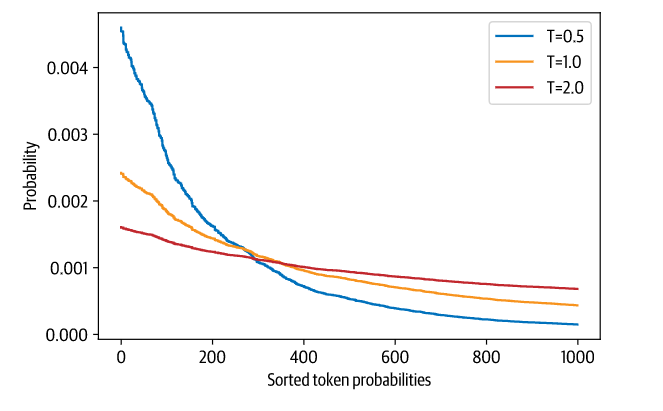

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

낮은 온도: 일관성

높은 온도: 다양성

-> 균형점 잘 찾기!

# 5.5 탑-K 및 뉴클리어스 샘플링

1. 두 가지 방식 모두 각 타임스텝에서 샘플링에 사용할 토큰의 개수를 줄인다는 개념에 기초
2. 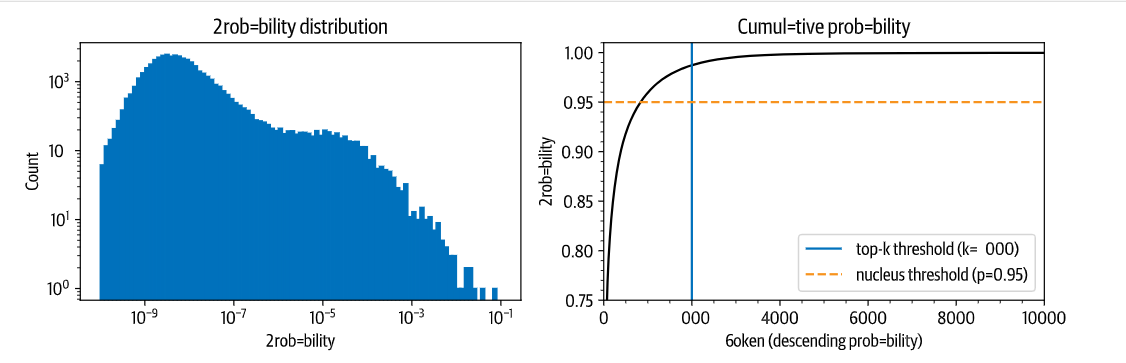
3. 탑-k 샘플링
    1. 확률이 가장 높은 k개 토큰에서만 샘플링해 확률이 낮은 토큰을 피함
    2. Long tail을 잘라내고 확률이 가장 높은 토큰에서만 샘플링하는 것이 가능해짐
    3. k값은 수동으로 선택해야 하고 실제 출력 분포에 상관없이 시퀀스의 각 선택에 동일하게 적용됨 -> 동적 컷오프 적용 ㅏㅇ법

In [ ]:
#top-K
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In [ ]:
#dynamic cut-off
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In [ ]:
#Both
output_toppp = model.generate(input_ids, max_length=max_length, do_sample=True, top_k=50, top_p=0.9)
print(tokenizer.decode(output_toppp[0]))